 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.autograd import Variable
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import torch.nn.functional as F

Скачаем обучающую и контрольную выборки.

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

fashion_type = {
  0: "T-shirt/top",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat", 
  5: "Sandal", 
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot"
}

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [ ]:
print("Train size:", len(trainset))


Train size: 60000


In [ ]:
print("Test size: ", len(testset))

Test size:  10000


In [ ]:
train_unique = trainset.targets.unique(return_counts=True)[1]
print(train_unique)
test_unique = testset.targets.unique(return_counts=True)[1]
print(test_unique)
print("Distribution in both train and test is even")

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])
tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])
Distribution in both train and test is even


T-shirt/top


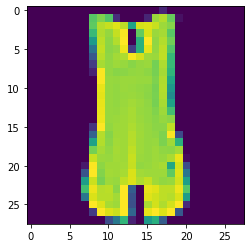

Pullover


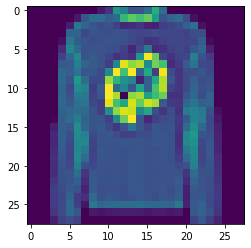

Bag


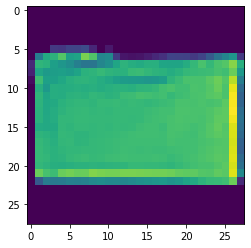

In [ ]:
print(fashion_type[trainset.targets[1].item()])
plt.imshow(trainset.data[4])
plt.show()
print(fashion_type[trainset.targets[123].item()])
plt.imshow(trainset.data[123])
plt.show()
print(fashion_type[trainset.targets[1234].item()])
plt.imshow(trainset.data[1234])
plt.show()

In [ ]:
def fit(model, optimizer, loss_fn, epochs = 5):
  loss_values = list()
  for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
      # зануляем градиенты (чтобы не было остатка с редыдущего шага)
      optimizer.zero_grad()
      loss = loss_fn(model(images), labels)
      # backward
      loss.backward()
      # обновляем
      optimizer.step()
      if(i == 1000):
        loss_values.append(loss.detach().cpu().item())
  plt.plot(loss_values)
  plt.show()

In [ ]:
def report(model, testloader):  
  model.eval()
  y_trues = list()
  y_hats = list()
  with torch.no_grad():
    for batch in testloader:
      y_pred = model(batch[0].cuda())
      y_hat = torch.argmax(y_pred, dim=1).detach().cpu()
      y_trues.extend(batch[1])
      y_hats.extend(y_hat)
  print(classification_report(y_hats, y_trues))

In [ ]:
#MLP
class MLP(torch.nn.Module):
# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
  def __init__(self, D_in, H, D_out):
    super(MLP, self).__init__()
    self.first = torch.nn.Linear(D_in, H[0])
    self.first_ReLu = torch.nn.ReLU()
    self.second = torch.nn.Linear(H[0], H[1])
    self.second_ReLu = torch.nn.ReLU()
    self.third = torch.nn.Linear(H[1], D_out)
  
  def forward(self, x):
    x = x.view(-1, 784)
    x = self.first(x)
    x = self.first_ReLu(x)
    x = self.second(x)
    x = self.second_ReLu(x)
    x = self.third(x)
    return x

In [ ]:
model = MLP(D_in = 784,H = [256, 128], D_out = 10)
model.cuda()
model.train()
for parameter in model.parameters():
  parameter.requires_grad = True
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


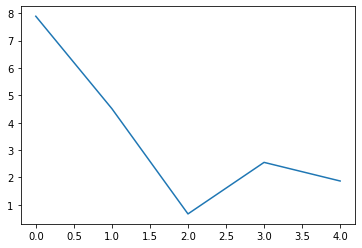

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       866
           1       0.95      0.98      0.96       964
           2       0.77      0.72      0.75      1065
           3       0.88      0.80      0.84      1090
           4       0.61      0.81      0.70       761
           5       0.91      0.93      0.92       983
           6       0.68      0.56      0.62      1216
           7       0.91      0.91      0.91      1005
           8       0.94      0.92      0.93      1021
           9       0.94      0.92      0.93      1029

    accuracy                           0.83     10000
   macro avg       0.83      0.84      0.83     10000
weighted avg       0.84      0.83      0.83     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)

In [ ]:
model = MLP(D_in = 784,H = [256, 128], D_out = 10)
model.cuda()
model.train()
for parameter in model.parameters():
  parameter.requires_grad = True
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


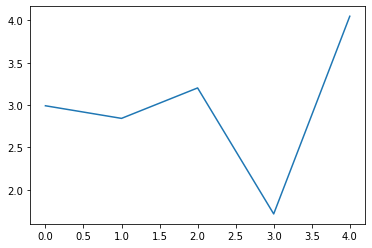

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       931
           1       0.97      0.99      0.98       977
           2       0.70      0.85      0.77       822
           3       0.91      0.87      0.89      1055
           4       0.87      0.73      0.79      1192
           5       0.97      0.97      0.97      1003
           6       0.72      0.70      0.71      1022
           7       0.95      0.95      0.95       999
           8       0.97      0.97      0.97       995
           9       0.96      0.96      0.96      1004

    accuracy                           0.88     10000
   macro avg       0.88      0.89      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)

In [ ]:
class CNN(torch.nn.Module):
# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
  def __init__(self, D_in, H, D_out):
    # вызов конструктора родителя
    super(CNN, self).__init__()
    # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
    # которую будем подавать в сеть, больше ничего
    # про входящие картинки знать не нужно
    self.first_conv = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    # out_channels - это количество фильтров, которые применятся для свёртки
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.second_conv = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.first = torch.nn.Linear(D_in, H[0])
    self.second = torch.nn.Linear(H[0], H[1])
    self.third = torch.nn.Linear(H[1], D_out)
  
  def forward(self, x):
    x = self.pool(F.relu(self.first_conv(x)))
    x = self.pool(F.relu(self.second_conv(x)))
    # print(x.shape)
    x = x.view(-1, 4 * 4 * 16)
    x = F.relu(self.first(x))
    x = F.relu(self.second(x))
    x = self.third(x)
    return x

In [ ]:
model = CNN(4 * 4 * 16, [128, 64], 10)

model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

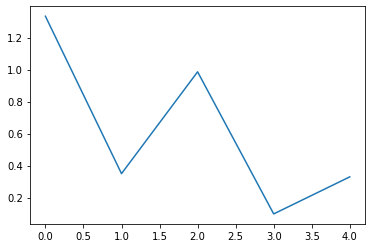

In [ ]:
fit(model, optimizer, loss_fn)

In [ ]:
report(model, testloader)

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1138
           1       0.97      0.99      0.98       989
           2       0.85      0.77      0.81      1097
           3       0.86      0.91      0.88       941
           4       0.80      0.80      0.80       989
           5       0.97      0.96      0.97      1009
           6       0.58      0.70      0.63       823
           7       0.94      0.95      0.94       989
           8       0.97      0.96      0.97      1011
           9       0.96      0.94      0.95      1014

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

